# 필요한 라이브러리 import

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
forward_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 선형성 검정

모든 변수 선형성 만족

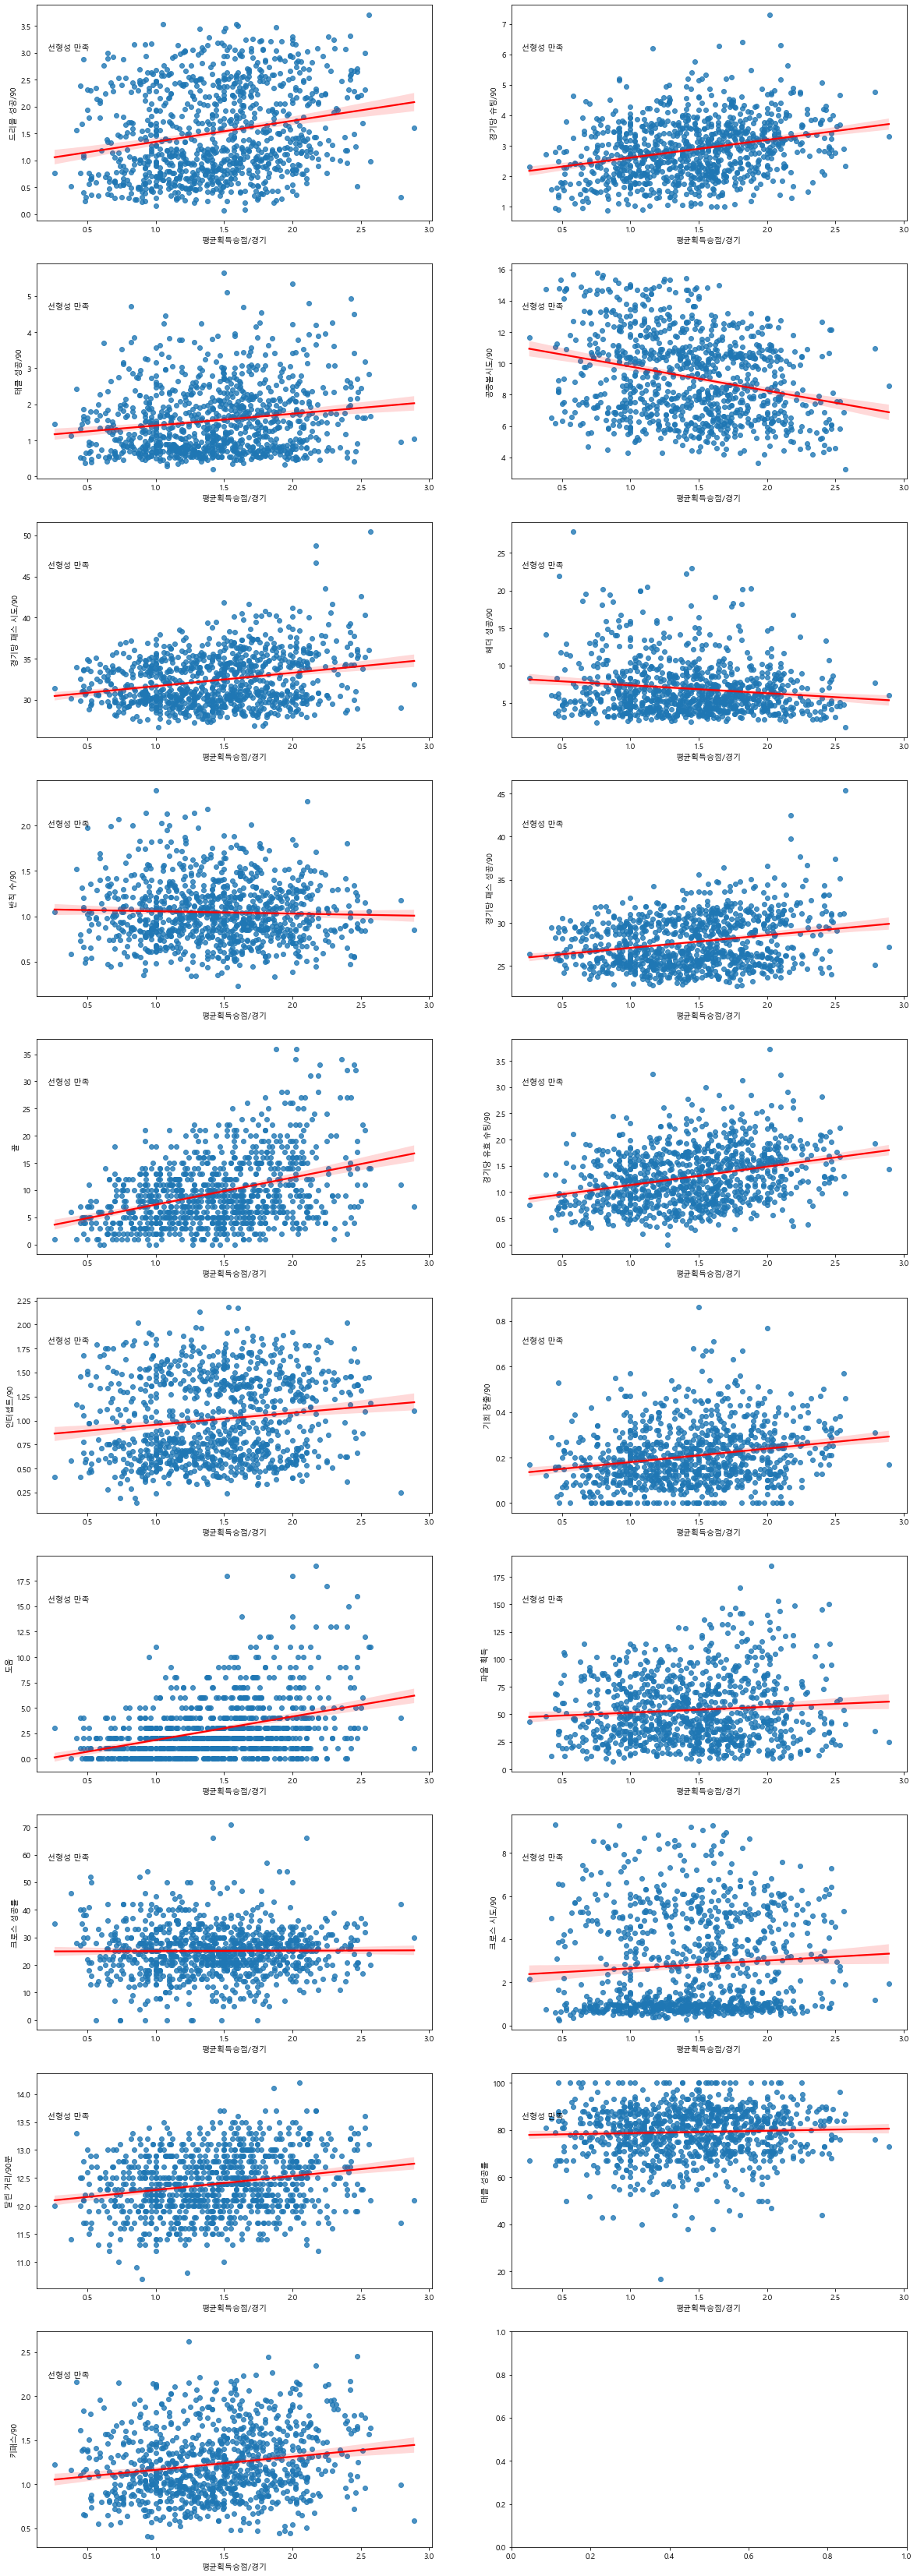

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=forward_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(forward_df[dependent_value],forward_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

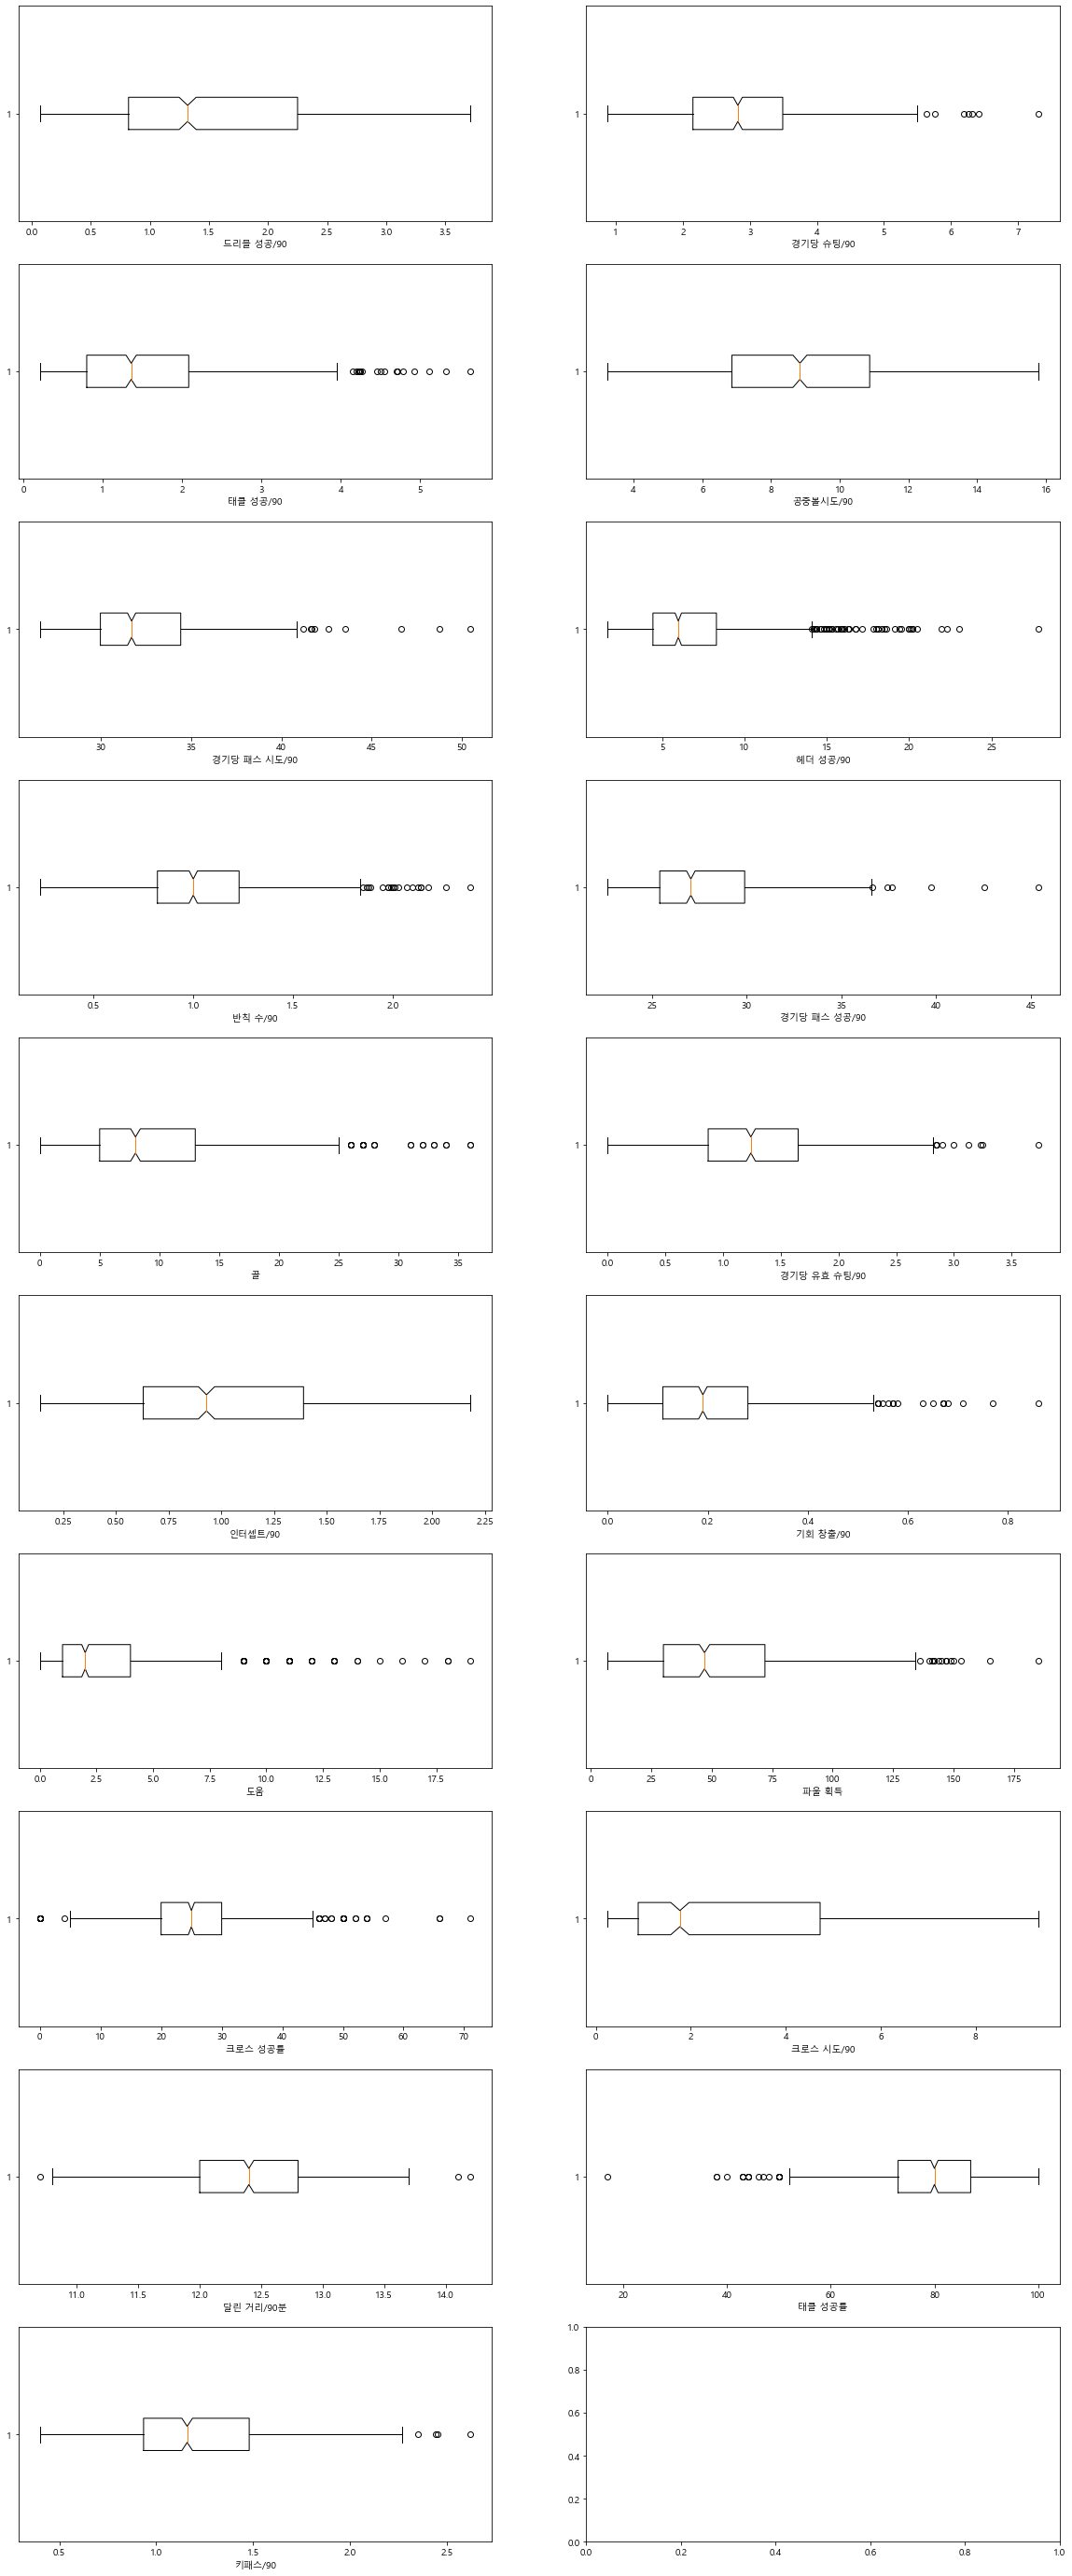

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 990개의 데이터 중 {len(total)} 개 입니다.')

드리블 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 슈팅/90중 이상치는 11개 비율은 약 1.111% 입니다

태클 성공/90중 이상치는 42개 비율은 약 4.242% 입니다

공중볼시도/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 패스 시도/90중 이상치는 19개 비율은 약 1.919% 입니다

헤더 성공/90중 이상치는 77개 비율은 약 7.778% 입니다

반칙 수/90중 이상치는 38개 비율은 약 3.838% 입니다

경기당 패스 성공/90중 이상치는 8개 비율은 약 0.808% 입니다

골중 이상치는 34개 비율은 약 3.434% 입니다

경기당 유효 슈팅/90중 이상치는 15개 비율은 약 1.515% 입니다

인터셉트/90중 이상치는 0개 비율은 약 0.0% 입니다

기회 창출/90중 이상치는 30개 비율은 약 3.03% 입니다

도움중 이상치는 100개 비율은 약 10.101% 입니다

파울 획득중 이상치는 25개 비율은 약 2.525% 입니다

크로스 성공률중 이상치는 46개 비율은 약 4.646% 입니다

크로스 시도/90중 이상치는 8개 비율은 약 0.808% 입니다

달린 거리/90분중 이상치는 5개 비율은 약 0.505% 입니다

태클 성공률중 이상치는 23개 비율은 약 2.323% 입니다

키패스/90중 이상치는 26개 비율은 약 2.626% 입니다

이상치가 있는 row의 갯수는 총 990개의 데이터 중 363 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

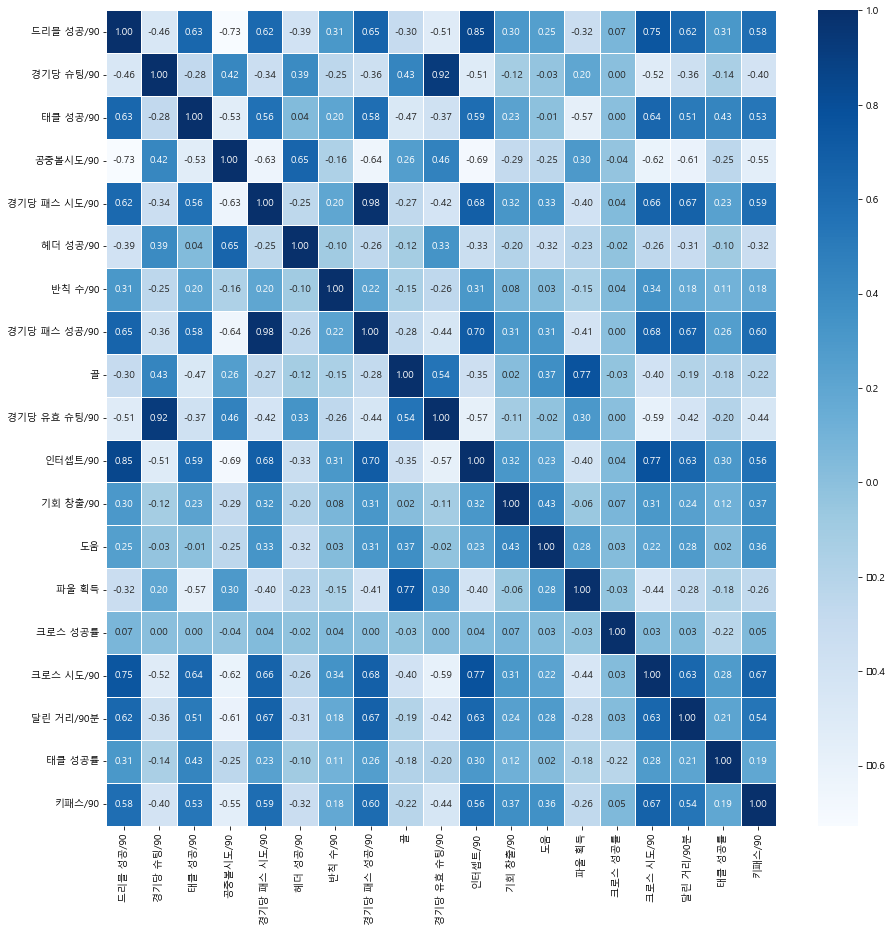

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = forward_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 독립변수 간 상관계수가 0.7이상인 변수들

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 슈팅/90,경기당 유효 슈팅/90,0.919081
1,경기당 패스 시도/90,경기당 패스 성공/90,0.975738


#### 종속변수와 독립변수간 상관계수

In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(forward_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,드리블 성공/90,평균획득승점/경기,0.228585
1,경기당 슈팅/90,평균획득승점/경기,0.281119
2,태클 성공/90,평균획득승점/경기,0.156097
3,공중볼시도/90,평균획득승점/경기,-0.240744
4,경기당 패스 시도/90,평균획득승점/경기,0.195827
5,헤더 성공/90,평균획득승점/경기,-0.101678
6,반칙 수/90,평균획득승점/경기,-0.018040
7,경기당 패스 성공/90,평균획득승점/경기,0.191469
8,골,평균획득승점/경기,0.336094
9,경기당 유효 슈팅/90,평균획득승점/경기,0.301633


### 다중공선성 확인

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.724547,도움
1,4.799466,기회 창출/90
2,9.625052,크로스 시도/90
3,9.817092,크로스 성공률
4,12.474020,반칙 수/90
5,13.158411,골
6,13.796837,태클 성공/90
7,15.672334,파울 획득
8,18.684251,헤더 성공/90
9,21.396413,드리블 성공/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [12]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [13]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(forward_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [14]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(forward_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])
    return df.sort_values(by='상관계수')

## 결측치 처리

결측치가 없음

## 패스 스타일을 통한 공격수 군집화

k : 2 , score: 5510.071934917474
k : 3 , score: 3260.4705302122416
k : 4 , score: 2275.6500080856827
k : 5 , score: 1501.7584442308678
k : 6 , score: 1112.5214742660937
k : 7 , score: 855.1222766000276
k : 8 , score: 679.3124567879726
k : 9 , score: 572.1171083690101


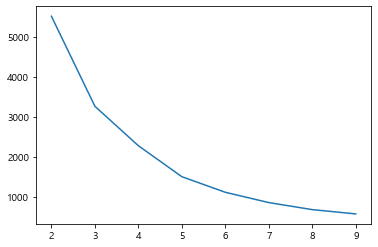

In [15]:
k_range = range(2,10)
inertia_arr = []

for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=123)
    kmeans.fit(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))
    inertia = kmeans.inertia_

    print(f'k : {k} , score: {inertia}')
    
    inertia_arr.append(inertia)
    
plt.plot(k_range,inertia_arr)

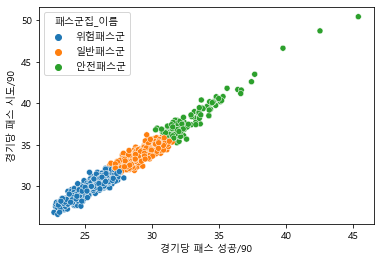

In [16]:
pass_kmeans = KMeans(n_clusters=3,random_state=123).fit(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))

forward_df['패스군집'] = pass_kmeans.predict(list(zip(forward_df['경기당 패스 성공/90'],forward_df['경기당 패스 시도/90'])))

forward_df['패스군집_이름'] = forward_df['패스군집'].map(lambda x : '일반패스군' if x == 0 else ('안전패스군' if x == 1 else '위험패스군'))

sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=forward_df,hue='패스군집_이름');

In [17]:
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 도움, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [18]:
forward_df[['골','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골,1.000000,0.543104,0.433125,0.378764
경기당 유효 슈팅/90,0.543104,1.000000,0.921081,0.305433
경기당 슈팅/90,0.433125,0.921081,1.000000,0.284880
평균획득승점/경기,0.378764,0.305433,0.284880,1.000000


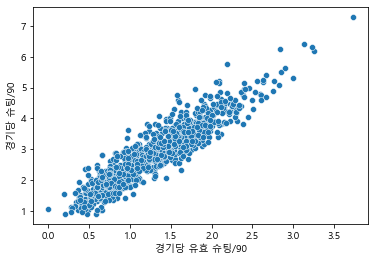

In [19]:
sns.scatterplot(x='경기당 유효 슈팅/90',y='경기당 슈팅/90',data=forward_df);

#### 피쳐 엔지니어링

In [20]:
# Goal_Shoot_linear
forward_df['GSL'] = (forward_df['경기당 유효 슈팅/90']+0.5) + (forward_df['경기당 슈팅/90']) + (forward_df['골']*1.3)

independent_value.add('GSL')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

forward_df[['이름','GSL']].sort_values(by='GSL',ascending=False).head()

,이름,GSL
333,Erling Haaland,55.73
3,Erling Haaland,55.64
259,Romelu Lukaku,53.62
866,Erling Haaland,50.00
196,Kylian Mbappé,49.88


#### 상관계수 확인 (통과)

In [21]:
forward_df[['GSL','평균획득승점/경기']].corr()

,GSL,평균획득승점/경기
GSL,1.000000,0.393941
평균획득승점/경기,0.393941,1.000000


In [22]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.588898,도움
1,4.749106,기회 창출/90
2,9.173653,크로스 시도/90
3,9.378384,크로스 성공률
4,12.406703,반칙 수/90
5,12.599216,GSL
6,13.416366,파울 획득
7,13.724054,태클 성공/90
8,17.397808,헤더 성공/90
9,20.700558,드리블 성공/90


In [23]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 다중공선성이 높고 종속변수와 상관관계가 없는 피쳐 순으로 삭제

In [24]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
2,공중볼시도/90,평균획득승점/경기,-0.240744
10,헤더 성공/90,평균획득승점/경기,-0.101678
13,반칙 수/90,평균획득승점/경기,-0.018040
7,크로스 성공률,평균획득승점/경기,0.012961
6,파울 획득,평균획득승점/경기,0.040846
12,태클 성공률,평균획득승점/경기,0.046058
8,크로스 시도/90,평균획득승점/경기,0.117011
3,인터셉트/90,평균획득승점/경기,0.132552
1,태클 성공/90,평균획득승점/경기,0.156097
14,키패스/90,평균획득승점/경기,0.181194


In [25]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.588898,도움
1,4.749106,기회 창출/90
2,9.173653,크로스 시도/90
3,9.378384,크로스 성공률
4,12.406703,반칙 수/90
5,12.599216,GSL
6,13.416366,파울 획득
7,13.724054,태클 성공/90
8,17.397808,헤더 성공/90
9,20.700558,드리블 성공/90


In [26]:
independent_value = independent_value - set(['달린 거리/90분','태클 성공률','파울 획득','공중볼시도/90','인터셉트/90'])

check_vif(independent_value)

,VIF 계수,종속변수
0,3.400309,도움
1,4.654132,기회 창출/90
2,5.681622,헤더 성공/90
3,6.316892,GSL
4,7.942552,크로스 성공률
5,8.194249,크로스 시도/90
6,9.847148,태클 성공/90
7,10.281640,반칙 수/90
8,13.017286,드리블 성공/90
9,18.461835,키패스/90


### 최종 종속변수

In [27]:
independent_value

{'GSL',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '헤더 성공/90'}

In [28]:
forward_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', '패스군집', '패스군집_이름', 'GSL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

### 독립변수,종속변수 정규화

In [29]:
# 데이터의 2/3 수준의 quantile 적용

forward_qt = QuantileTransformer(n_quantiles=1000).fit(forward_df.loc[:,independent_value])
forward_df.loc[:,independent_value] = forward_qt.transform(forward_df.loc[:,independent_value])

In [30]:
independent_value

{'GSL',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '헤더 성공/90'}

# 패스 군집별 모델 생성

In [34]:
safe_pass_df = forward_df[forward_df['패스군집_이름']=='안전패스군']
normal_pass_df = forward_df[forward_df['패스군집_이름']=='일반패스군']
danger_pass_df = forward_df[forward_df['패스군집_이름']=='위험패스군']

In [35]:
def tensorflow_by_pass(df):
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(df.loc[:,independent_value],df.loc[:,dependent_value],test_size=0.2,random_state=123)
    
    inputs_layer = Input(shape=(len(independent_value),))
    hidden1 = Dense(64,activation='relu',kernel_regularizer=L2(l2=0.015))(inputs_layer)
    hidden2 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.015))(hidden1)
    hidden3 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.015))(hidden2)
    hidden4 = Dense(8,activation='relu',kernel_regularizer=L2(l2=0.015))(hidden3)
    output = Dense(1,activation='linear')(hidden4)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
    model.fit(fx_train,fy_train,batch_size=70,epochs=600,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    
    return model,mae

## 안전패스군 모델 생성

In [36]:
safe_model, safe_mae = tensorflow_by_pass(safe_pass_df)
safe_mae

Epoch 1/600
2/2 [==============================] - 1s 192ms/step - loss: 4.5755 - val_loss: 4.0509
Epoch 2/600
2/2 [==============================] - 0s 32ms/step - loss: 4.3757 - val_loss: 3.9137
Epoch 3/600
2/2 [==============================] - 0s 34ms/step - loss: 4.2088 - val_loss: 3.7638
Epoch 4/600
2/2 [==============================] - 0s 32ms/step - loss: 4.0402 - val_loss: 3.6016
Epoch 5/600
2/2 [==============================] - 0s 31ms/step - loss: 3.8563 - val_loss: 3.4389
Epoch 6/600
2/2 [==============================] - 0s 33ms/step - loss: 3.6731 - val_loss: 3.2746
Epoch 7/600
2/2 [==============================] - 0s 30ms/step - loss: 3.4873 - val_loss: 3.1045
Epoch 8/600
2/2 [==============================] - 0s 33ms/step - loss: 3.3053 - val_loss: 2.9327
Epoch 9/600
2/2 [==============================] - 0s 34ms/step - loss: 3.1251 - val_loss: 2.7604
Epoch 10/600
2/2 [==============================] - 0s 34ms/step - loss: 2.9400 - val_loss: 2.5871
Epoch 11/600
2/2 [

Epoch 84/600
2/2 [==============================] - 0s 22ms/step - loss: 0.6430 - val_loss: 0.6404
Epoch 85/600
2/2 [==============================] - 0s 20ms/step - loss: 0.6377 - val_loss: 0.6355
Epoch 86/600
2/2 [==============================] - 0s 21ms/step - loss: 0.6325 - val_loss: 0.6306
Epoch 87/600
2/2 [==============================] - 0s 22ms/step - loss: 0.6274 - val_loss: 0.6256
Epoch 88/600
2/2 [==============================] - 0s 19ms/step - loss: 0.6224 - val_loss: 0.6205
Epoch 89/600
2/2 [==============================] - 0s 20ms/step - loss: 0.6174 - val_loss: 0.6152
Epoch 90/600
2/2 [==============================] - 0s 23ms/step - loss: 0.6126 - val_loss: 0.6103
Epoch 91/600
2/2 [==============================] - 0s 25ms/step - loss: 0.6078 - val_loss: 0.6056
Epoch 92/600
2/2 [==============================] - 0s 30ms/step - loss: 0.6031 - val_loss: 0.6008
Epoch 93/600
2/2 [==============================] - 0s 22ms/step - loss: 0.5985 - val_loss: 0.5961
Epoch 94/6

2/2 [==============================] - 0s 22ms/step - loss: 0.3935 - val_loss: 0.3912
Epoch 167/600
2/2 [==============================] - 0s 23ms/step - loss: 0.3916 - val_loss: 0.3895
Epoch 168/600
2/2 [==============================] - 0s 22ms/step - loss: 0.3899 - val_loss: 0.3875
Epoch 169/600
2/2 [==============================] - 0s 22ms/step - loss: 0.3883 - val_loss: 0.3858
Epoch 170/600
2/2 [==============================] - 0s 26ms/step - loss: 0.3872 - val_loss: 0.3846
Epoch 171/600
2/2 [==============================] - 0s 22ms/step - loss: 0.3853 - val_loss: 0.3827
Epoch 172/600
2/2 [==============================] - 0s 21ms/step - loss: 0.3836 - val_loss: 0.3814
Epoch 173/600
2/2 [==============================] - 0s 22ms/step - loss: 0.3819 - val_loss: 0.3798
Epoch 174/600
2/2 [==============================] - 0s 22ms/step - loss: 0.3803 - val_loss: 0.3784
Epoch 175/600
2/2 [==============================] - 0s 21ms/step - loss: 0.3788 - val_loss: 0.3770
Epoch 176/600


2/2 [==============================] - 0s 22ms/step - loss: 0.2983 - val_loss: 0.2948
Epoch 249/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2978 - val_loss: 0.2938
Epoch 250/600
2/2 [==============================] - 0s 27ms/step - loss: 0.2967 - val_loss: 0.2938
Epoch 251/600
2/2 [==============================] - 0s 22ms/step - loss: 0.2960 - val_loss: 0.2939
Epoch 252/600
2/2 [==============================] - 0s 26ms/step - loss: 0.2952 - val_loss: 0.2931
Epoch 253/600
2/2 [==============================] - 0s 27ms/step - loss: 0.2943 - val_loss: 0.2916
Epoch 254/600
2/2 [==============================] - 0s 30ms/step - loss: 0.2938 - val_loss: 0.2902
Epoch 255/600
2/2 [==============================] - 0s 33ms/step - loss: 0.2930 - val_loss: 0.2894
Epoch 256/600
2/2 [==============================] - 0s 35ms/step - loss: 0.2920 - val_loss: 0.2881
Epoch 257/600
2/2 [==============================] - 0s 31ms/step - loss: 0.2915 - val_loss: 0.2870
Epoch 258/600


2/2 [==============================] - 0s 23ms/step - loss: 0.2482 - val_loss: 0.2429
Epoch 331/600
2/2 [==============================] - 0s 28ms/step - loss: 0.2479 - val_loss: 0.2420
Epoch 332/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2477 - val_loss: 0.2417
Epoch 333/600
2/2 [==============================] - 0s 26ms/step - loss: 0.2471 - val_loss: 0.2417
Epoch 334/600
2/2 [==============================] - 0s 24ms/step - loss: 0.2463 - val_loss: 0.2428
Epoch 335/600
2/2 [==============================] - 0s 29ms/step - loss: 0.2458 - val_loss: 0.2443
Epoch 336/600
2/2 [==============================] - 0s 24ms/step - loss: 0.2462 - val_loss: 0.2450
Epoch 337/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2462 - val_loss: 0.2433
Epoch 338/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2450 - val_loss: 0.2403
Epoch 339/600
2/2 [==============================] - 0s 24ms/step - loss: 0.2449 - val_loss: 0.2388
Epoch 340/600


2/2 [==============================] - 0s 24ms/step - loss: 0.2186 - val_loss: 0.2138
Epoch 413/600
2/2 [==============================] - 0s 27ms/step - loss: 0.2179 - val_loss: 0.2127
Epoch 414/600
2/2 [==============================] - 0s 27ms/step - loss: 0.2176 - val_loss: 0.2116
Epoch 415/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2174 - val_loss: 0.2104
Epoch 416/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2174 - val_loss: 0.2099
Epoch 417/600
2/2 [==============================] - 0s 22ms/step - loss: 0.2175 - val_loss: 0.2098
Epoch 418/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2170 - val_loss: 0.2097
Epoch 419/600
2/2 [==============================] - 0s 22ms/step - loss: 0.2165 - val_loss: 0.2109
Epoch 420/600
2/2 [==============================] - 0s 23ms/step - loss: 0.2158 - val_loss: 0.2115
Epoch 421/600
2/2 [==============================] - 0s 22ms/step - loss: 0.2162 - val_loss: 0.2117
Epoch 422/600


2/2 [==============================] - 0s 23ms/step - loss: 0.1992 - val_loss: 0.1921
Epoch 495/600
2/2 [==============================] - 0s 26ms/step - loss: 0.1990 - val_loss: 0.1924
Epoch 496/600
2/2 [==============================] - 0s 23ms/step - loss: 0.1987 - val_loss: 0.1922
Epoch 497/600
2/2 [==============================] - 0s 21ms/step - loss: 0.1985 - val_loss: 0.1921
Epoch 498/600
2/2 [==============================] - 0s 26ms/step - loss: 0.1983 - val_loss: 0.1923
Epoch 499/600
2/2 [==============================] - 0s 27ms/step - loss: 0.1982 - val_loss: 0.1923
Epoch 500/600
2/2 [==============================] - 0s 21ms/step - loss: 0.1980 - val_loss: 0.1916
Epoch 501/600
2/2 [==============================] - 0s 23ms/step - loss: 0.1983 - val_loss: 0.1910
Epoch 502/600
2/2 [==============================] - 0s 25ms/step - loss: 0.1975 - val_loss: 0.1917
Epoch 503/600
2/2 [==============================] - 0s 26ms/step - loss: 0.1975 - val_loss: 0.1925
Epoch 504/600


2/2 [==============================] - 0s 21ms/step - loss: 0.1871 - val_loss: 0.1811
Epoch 577/600
2/2 [==============================] - 0s 24ms/step - loss: 0.1867 - val_loss: 0.1796
Epoch 578/600
2/2 [==============================] - 0s 21ms/step - loss: 0.1871 - val_loss: 0.1784
Epoch 579/600
2/2 [==============================] - 0s 23ms/step - loss: 0.1864 - val_loss: 0.1785
Epoch 580/600
2/2 [==============================] - 0s 24ms/step - loss: 0.1863 - val_loss: 0.1790
Epoch 581/600
2/2 [==============================] - 0s 22ms/step - loss: 0.1862 - val_loss: 0.1791
Epoch 582/600
2/2 [==============================] - 0s 22ms/step - loss: 0.1863 - val_loss: 0.1787
Epoch 583/600
2/2 [==============================] - 0s 26ms/step - loss: 0.1858 - val_loss: 0.1791
Epoch 584/600
2/2 [==============================] - 0s 20ms/step - loss: 0.1858 - val_loss: 0.1790
Epoch 585/600
2/2 [==============================] - 0s 20ms/step - loss: 0.1857 - val_loss: 0.1783
Epoch 586/600


0.26444461749150205

## 일반패스군 모델 생성

In [37]:
normal_model, normal_mae = tensorflow_by_pass(normal_pass_df)
normal_mae

Epoch 1/600
4/4 [==============================] - 1s 47ms/step - loss: 3.4693 - val_loss: 3.0688
Epoch 2/600
4/4 [==============================] - 0s 9ms/step - loss: 3.2065 - val_loss: 2.7862
Epoch 3/600
4/4 [==============================] - 0s 9ms/step - loss: 2.9034 - val_loss: 2.5040
Epoch 4/600
4/4 [==============================] - 0s 9ms/step - loss: 2.5927 - val_loss: 2.2126
Epoch 5/600
4/4 [==============================] - 0s 9ms/step - loss: 2.2700 - val_loss: 1.9022
Epoch 6/600
4/4 [==============================] - 0s 10ms/step - loss: 1.9466 - val_loss: 1.6318
Epoch 7/600
4/4 [==============================] - 0s 8ms/step - loss: 1.6686 - val_loss: 1.4300
Epoch 8/600
4/4 [==============================] - 0s 9ms/step - loss: 1.4674 - val_loss: 1.3141
Epoch 9/600
4/4 [==============================] - 0s 9ms/step - loss: 1.3462 - val_loss: 1.2822
Epoch 10/600
4/4 [==============================] - 0s 9ms/step - loss: 1.3199 - val_loss: 1.2989
Epoch 11/600
4/4 [=========

4/4 [==============================] - 0s 9ms/step - loss: 0.3781 - val_loss: 0.3842
Epoch 85/600
4/4 [==============================] - 0s 8ms/step - loss: 0.3742 - val_loss: 0.3776
Epoch 86/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3705 - val_loss: 0.3770
Epoch 87/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3670 - val_loss: 0.3769
Epoch 88/600
4/4 [==============================] - 0s 11ms/step - loss: 0.3646 - val_loss: 0.3702
Epoch 89/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3616 - val_loss: 0.3666
Epoch 90/600
4/4 [==============================] - 0s 10ms/step - loss: 0.3587 - val_loss: 0.3680
Epoch 91/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3556 - val_loss: 0.3620
Epoch 92/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3520 - val_loss: 0.3579
Epoch 93/600
4/4 [==============================] - 0s 9ms/step - loss: 0.3497 - val_loss: 0.3577
Epoch 94/600
4/4 [=============

4/4 [==============================] - 0s 8ms/step - loss: 0.2416 - val_loss: 0.2564
Epoch 167/600
4/4 [==============================] - 0s 10ms/step - loss: 0.2406 - val_loss: 0.2515
Epoch 168/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2400 - val_loss: 0.2517
Epoch 169/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2395 - val_loss: 0.2531
Epoch 170/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2383 - val_loss: 0.2516
Epoch 171/600
4/4 [==============================] - 0s 8ms/step - loss: 0.2381 - val_loss: 0.2491
Epoch 172/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2373 - val_loss: 0.2522
Epoch 173/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2369 - val_loss: 0.2508
Epoch 174/600
4/4 [==============================] - 0s 8ms/step - loss: 0.2354 - val_loss: 0.2471
Epoch 175/600
4/4 [==============================] - 0s 10ms/step - loss: 0.2360 - val_loss: 0.2483
Epoch 176/600
4/4 [===

4/4 [==============================] - 0s 10ms/step - loss: 0.2062 - val_loss: 0.2210
Epoch 249/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2071 - val_loss: 0.2206
Epoch 250/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2070 - val_loss: 0.2259
Epoch 251/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2064 - val_loss: 0.2203
Epoch 252/600
4/4 [==============================] - 0s 10ms/step - loss: 0.2055 - val_loss: 0.2213
Epoch 253/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2051 - val_loss: 0.2212
Epoch 254/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2065 - val_loss: 0.2193
Epoch 255/600
4/4 [==============================] - 0s 10ms/step - loss: 0.2040 - val_loss: 0.2253
Epoch 256/600
4/4 [==============================] - 0s 9ms/step - loss: 0.2062 - val_loss: 0.2245
Epoch 257/600
4/4 [==============================] - 0s 10ms/step - loss: 0.2092 - val_loss: 0.2174
Epoch 258/600
4/4 [=

4/4 [==============================] - 0s 9ms/step - loss: 0.1969 - val_loss: 0.2093
Epoch 331/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1942 - val_loss: 0.2144
Epoch 332/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1957 - val_loss: 0.2146
Epoch 333/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1946 - val_loss: 0.2100
Epoch 334/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1942 - val_loss: 0.2113
Epoch 335/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1944 - val_loss: 0.2152
Epoch 336/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1944 - val_loss: 0.2100
Epoch 337/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1950 - val_loss: 0.2118
Epoch 338/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1944 - val_loss: 0.2091
Epoch 339/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1946 - val_loss: 0.2143
Epoch 340/600
4/4 [===

4/4 [==============================] - 0s 10ms/step - loss: 0.1906 - val_loss: 0.2107
Epoch 413/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1893 - val_loss: 0.2081
Epoch 414/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1890 - val_loss: 0.2066
Epoch 415/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1909 - val_loss: 0.2050
Epoch 416/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1885 - val_loss: 0.2129
Epoch 417/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1899 - val_loss: 0.2117
Epoch 418/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1901 - val_loss: 0.2061
Epoch 419/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1887 - val_loss: 0.2081
Epoch 420/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1885 - val_loss: 0.2088
Epoch 421/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1888 - val_loss: 0.2080
Epoch 422/600
4/4 [=

4/4 [==============================] - 0s 8ms/step - loss: 0.1876 - val_loss: 0.2050
Epoch 495/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1862 - val_loss: 0.2078
Epoch 496/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1876 - val_loss: 0.2059
Epoch 497/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1863 - val_loss: 0.2023
Epoch 498/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1873 - val_loss: 0.2066
Epoch 499/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1893 - val_loss: 0.2136
Epoch 500/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1871 - val_loss: 0.2026
Epoch 501/600
4/4 [==============================] - 0s 8ms/step - loss: 0.1880 - val_loss: 0.2036
Epoch 502/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1863 - val_loss: 0.2126
Epoch 503/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1875 - val_loss: 0.2042
Epoch 504/600
4/4 [==

Epoch 576/600
4/4 [==============================] - 0s 24ms/step - loss: 0.1835 - val_loss: 0.2070
Epoch 577/600
4/4 [==============================] - 0s 20ms/step - loss: 0.1847 - val_loss: 0.2046
Epoch 578/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1844 - val_loss: 0.2032
Epoch 579/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1849 - val_loss: 0.2056
Epoch 580/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1849 - val_loss: 0.2016
Epoch 581/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1846 - val_loss: 0.2066
Epoch 582/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1840 - val_loss: 0.2042
Epoch 583/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1848 - val_loss: 0.2029
Epoch 584/600
4/4 [==============================] - 0s 10ms/step - loss: 0.1843 - val_loss: 0.2080
Epoch 585/600
4/4 [==============================] - 0s 9ms/step - loss: 0.1845 - val_loss: 0.2037
Epoch 

0.3310398584337377

## 위험패스군 모델 생성

In [38]:
danger_model, danger_mae = tensorflow_by_pass(danger_pass_df)
danger_mae

Epoch 1/600
6/6 [==============================] - 1s 62ms/step - loss: 2.6588 - val_loss: 2.1691
Epoch 2/600
6/6 [==============================] - 0s 7ms/step - loss: 1.8545 - val_loss: 1.6044
Epoch 3/600
6/6 [==============================] - 0s 7ms/step - loss: 1.5909 - val_loss: 1.5721
Epoch 4/600
6/6 [==============================] - 0s 7ms/step - loss: 1.5427 - val_loss: 1.4719
Epoch 5/600
6/6 [==============================] - 0s 7ms/step - loss: 1.4265 - val_loss: 1.3761
Epoch 6/600
6/6 [==============================] - 0s 7ms/step - loss: 1.3554 - val_loss: 1.3309
Epoch 7/600
6/6 [==============================] - 0s 7ms/step - loss: 1.3033 - val_loss: 1.2711
Epoch 8/600
6/6 [==============================] - 0s 7ms/step - loss: 1.2428 - val_loss: 1.2172
Epoch 9/600
6/6 [==============================] - 0s 7ms/step - loss: 1.1957 - val_loss: 1.1746
Epoch 10/600
6/6 [==============================] - 0s 7ms/step - loss: 1.1523 - val_loss: 1.1345
Epoch 11/600
6/6 [==========

6/6 [==============================] - 0s 9ms/step - loss: 0.2900 - val_loss: 0.2991
Epoch 85/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2875 - val_loss: 0.2963
Epoch 86/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2851 - val_loss: 0.2944
Epoch 87/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2832 - val_loss: 0.2912
Epoch 88/600
6/6 [==============================] - 0s 8ms/step - loss: 0.2805 - val_loss: 0.2905
Epoch 89/600
6/6 [==============================] - 0s 9ms/step - loss: 0.2785 - val_loss: 0.2870
Epoch 90/600
6/6 [==============================] - 0s 6ms/step - loss: 0.2780 - val_loss: 0.2844
Epoch 91/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2749 - val_loss: 0.2865
Epoch 92/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2723 - val_loss: 0.2804
Epoch 93/600
6/6 [==============================] - 0s 7ms/step - loss: 0.2707 - val_loss: 0.2783
Epoch 94/600
6/6 [===============

6/6 [==============================] - 0s 7ms/step - loss: 0.1997 - val_loss: 0.2093
Epoch 168/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1988 - val_loss: 0.2063
Epoch 169/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1979 - val_loss: 0.2068
Epoch 170/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1974 - val_loss: 0.2068
Epoch 171/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1980 - val_loss: 0.2051
Epoch 172/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1963 - val_loss: 0.2081
Epoch 173/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1972 - val_loss: 0.2046
Epoch 174/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1955 - val_loss: 0.2056
Epoch 175/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1953 - val_loss: 0.2041
Epoch 176/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1948 - val_loss: 0.2035
Epoch 177/600
6/6 [=====

Epoch 250/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1789 - val_loss: 0.1874
Epoch 251/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1782 - val_loss: 0.1898
Epoch 252/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1787 - val_loss: 0.1879
Epoch 253/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1789 - val_loss: 0.1874
Epoch 254/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1780 - val_loss: 0.1896
Epoch 255/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1798 - val_loss: 0.1869
Epoch 256/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1788 - val_loss: 0.1881
Epoch 257/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1777 - val_loss: 0.1869
Epoch 258/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1780 - val_loss: 0.1866
Epoch 259/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1778 - val_loss: 0.1872
Epoch 260/

6/6 [==============================] - 0s 8ms/step - loss: 0.1722 - val_loss: 0.1809
Epoch 333/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1728 - val_loss: 0.1811
Epoch 334/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1730 - val_loss: 0.1834
Epoch 335/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1744 - val_loss: 0.1808
Epoch 336/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1725 - val_loss: 0.1846
Epoch 337/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1754 - val_loss: 0.1810
Epoch 338/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1726 - val_loss: 0.1832
Epoch 339/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1723 - val_loss: 0.1805
Epoch 340/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1717 - val_loss: 0.1825
Epoch 341/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1741 - val_loss: 0.1819
Epoch 342/600
6/6 [=====

Epoch 415/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1691 - val_loss: 0.1782
Epoch 416/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1690 - val_loss: 0.1781
Epoch 417/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1686 - val_loss: 0.1789
Epoch 418/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1688 - val_loss: 0.1783
Epoch 419/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1684 - val_loss: 0.1773
Epoch 420/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1686 - val_loss: 0.1784
Epoch 421/600
6/6 [==============================] - 0s 6ms/step - loss: 0.1686 - val_loss: 0.1777
Epoch 422/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1684 - val_loss: 0.1776
Epoch 423/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1682 - val_loss: 0.1777
Epoch 424/600
6/6 [==============================] - 0s 7ms/step - loss: 0.1681 - val_loss: 0.1774
Epoch 425/

6/6 [==============================] - 0s 8ms/step - loss: 0.1665 - val_loss: 0.1747
Epoch 498/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1659 - val_loss: 0.1766
Epoch 499/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1668 - val_loss: 0.1748
Epoch 500/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1668 - val_loss: 0.1758
Epoch 501/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1679 - val_loss: 0.1751
Epoch 502/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1659 - val_loss: 0.1760
Epoch 503/600
6/6 [==============================] - 0s 10ms/step - loss: 0.1660 - val_loss: 0.1749
Epoch 504/600
6/6 [==============================] - 0s 9ms/step - loss: 0.1659 - val_loss: 0.1753
Epoch 505/600
6/6 [==============================] - 0s 13ms/step - loss: 0.1662 - val_loss: 0.1760
Epoch 506/600
6/6 [==============================] - 0s 10ms/step - loss: 0.1672 - val_loss: 0.1761
Epoch 507/600
6/6 [=

6/6 [==============================] - 0s 8ms/step - loss: 0.1670 - val_loss: 0.1741
Epoch 580/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1657 - val_loss: 0.1727
Epoch 581/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1652 - val_loss: 0.1742
Epoch 582/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1640 - val_loss: 0.1727
Epoch 583/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1642 - val_loss: 0.1728
Epoch 584/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1653 - val_loss: 0.1732
Epoch 585/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1645 - val_loss: 0.1725
Epoch 586/600
6/6 [==============================] - 0s 9ms/step - loss: 0.1633 - val_loss: 0.1751
Epoch 587/600
6/6 [==============================] - 0s 9ms/step - loss: 0.1659 - val_loss: 0.1728
Epoch 588/600
6/6 [==============================] - 0s 8ms/step - loss: 0.1661 - val_loss: 0.1726
Epoch 589/600
6/6 [=====

0.2997766455014546

In [39]:
with open('./models/forward_qt.pickle','wb') as f:
    pickle.dump(forward_qt,f)
    
danger_model.save('./models/danger_forward_nn.h5')
safe_model.save('./models/safe_forward_nn.h5')
normal_model.save('./models/normal_forward_nn.h5')

# 모델검정

In [40]:
danger_index = danger_pass_df.index
normal_index = normal_pass_df.index
safe_index = safe_pass_df.index

forward_df.loc[danger_index,'predict'] = danger_model.predict(danger_pass_df.loc[:,independent_value])
forward_df.loc[safe_index,'predict'] = safe_model.predict(safe_pass_df.loc[:,independent_value])
forward_df.loc[normal_index,'predict'] = normal_model.predict(normal_pass_df.loc[:,independent_value])

In [41]:
residual = forward_df['평균획득승점/경기'] - forward_df['predict']

## 잔차의 정규성 검정

In [42]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9925738573074341, pvalue=8.741381316212937e-05)

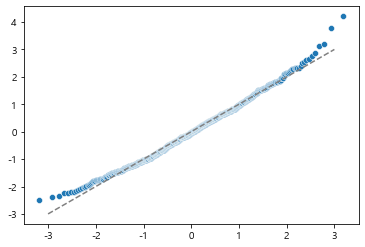

In [50]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

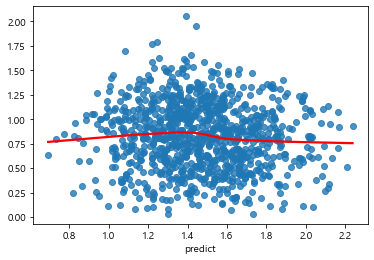

In [44]:
sns.regplot(forward_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [45]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['predict'])

LeveneResult(statistic=285.05520572555963, pvalue=8.908227532584059e-60)

In [46]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

1.0808032647877817

In [47]:
mean_absolute_error(forward_df['평균획득승점/경기'],forward_df['predict'])

0.2902366066150881

In [48]:
np.sqrt(mean_squared_error(forward_df['평균획득승점/경기'],forward_df['predict']))

0.3610197084119337